1. [Импорт библиотек](#imp)
2. [Таблицы](#tbl)
3. [Объединение таблиц](#merge)
4. [Разделение таблиц на исследуемые группы](#grp)
5. [Расчеты метрик](#mtr)
6. [Проверка гипотез](#hpt)

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.
- группа А - контрольная группа
- группа B - целевая группа
<br>
<br>
Цель исследования выявить:
<br>
- Имеются ли различия в показателях и с чем они могут быть связаны
- Являются ли эти различия статистически значимыми
- Стоит ли запускать новую механику на всех пользователей

# 1. Работа с данными
<a id="imp"></a>

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import math
from scipy import stats as st
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
#запись исследуемых таблиц в переменные
groups= pd.read_csv('https://raw.githubusercontent.com/maxikos8/-/main/groups.csv', sep=';')
checks =pd.read_csv('https://raw.githubusercontent.com/maxikos8/-/main/checks.csv', sep=';')
active = pd.read_csv('https://raw.githubusercontent.com/maxikos8/-/main/active_studs.csv',sep=';')

- groups : датафрейм с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
- active : датафрейм с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
- checks : датафрейм с информацией об оплатах пользователей в дни проведения эксперимента

In [3]:
#изменение названия колонок для удобства
groups.columns=['student_id','group']
#вывод 10 случайных строк
groups.sample(10)

,student_id,group
5934,1202898,A
16828,3620720,A
11279,192465,B
19624,2195950,B
28162,383438,B
45418,1050359,B
22446,1148887,B
20781,173559,B
6189,1606636,B
8291,2010662,B


<a id="tbl"></a>

In [4]:
#соотношение исследуемых групп среди всех клиентов
groups['group'].value_counts(normalize=True)

B    0.80298
A    0.19702
Name: group, dtype: float64

In [5]:
#информация о таблице со всеми клиентами
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  74576 non-null  int64 
 1   group       74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
#вывод 10 случайных строк таблицы
checks.sample(10)

,student_id,rev
165,1123519,990.0000
10,150911,290.0000
188,1346450,580.0000
411,4038035,199.0000
59,393127,290.0000
343,3274600,1900.0001
501,5211975,290.0000
276,2633282,199.0000
175,1220488,1980.0000
106,521164,1900.0000


In [7]:
#просмотр уникальности оплативших клиентов
checks['student_id'].nunique()

541

Все оплатившие клиенты уникальны, нет клиентов совершиших 2 и более оплаты

In [8]:
#вывод информации о таблице
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [9]:
#вывод 10 случайных строк
active.sample(10)

,student_id
465,1905242
8179,4300746
4152,454461
8213,4896037
924,5367353
832,3235927
2645,4012069
2080,1091128
2563,5502129
7587,1717249


In [10]:
#вывод информации о таблице
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [11]:
#группировка таблиц активных клиентов для обозначения их группы, метод группировки inner
active = pd.merge(active,groups,on='student_id')

In [12]:
#группировка таблиц оплативших клиентов для обозначения их группы, метод группировки inner
checks = pd.merge(checks,groups,on='student_id')

In [13]:
#группировка таблиц активных клиентов и оплативших для создания общего датафрейма, метод группировки inner
df = pd.merge(checks,active,on=['student_id','group'],how='outer')

In [14]:
#вывод информации общей таблицы
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8490 entries, 0 to 8489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8490 non-null   int64  
 1   rev         541 non-null    float64
 2   group       8490 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 265.3+ KB


In [15]:
#соотношение групп исследуемых клиентов в общей таблице
df['group'].value_counts(normalize=True)

B    0.81543
A    0.18457
Name: group, dtype: float64

Соотношение групп исследуемых клиентов  среди активных, имеет незначительное отклонение от общего списка клиентов

In [16]:
#выделим датафрейм с оплатившими клиентами
df_rev = df.loc[~df['rev'].isna()]

In [17]:
#информация о таблице оплативших клиентов
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
 2   group       541 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 16.9+ KB


In [18]:
df_rev.head()

,student_id,rev,group
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


In [19]:
#количество оплативших клиентов из разных групп
df_rev['group'].value_counts()

B    434
A    107
Name: group, dtype: int64

In [20]:
#соотношение оплативших клиентов из разных групп
df_rev['group'].value_counts(normalize=True)

B    0.802218
A    0.197782
Name: group, dtype: float64

Соотношение групп исследуемых клиентов среди оплативших, имеет незначительное отклонение от активного списка клиентов



In [21]:
#разделение общего датафрейма на группы
df_a = df.loc[df['group'] == 'A']
df_b = df.loc[df['group'] == 'B']

In [22]:
#вывод информации
display(df_a.info())
df_a.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1567 entries, 0 to 8484
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  1567 non-null   int64  
 1   rev         107 non-null    float64
 2   group       1567 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 49.0+ KB


None

,student_id,rev,group
0,1627,990.0,A
9,114366,690.0,A
16,212994,690.0,A
17,218393,690.0,A
18,225541,690.0,A


In [23]:
#вывод информации
display(df_b.info())
df_b.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 1 to 8489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  6923 non-null   int64  
 1   rev         434 non-null    float64
 2   group       6923 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 216.3+ KB


None

,student_id,rev,group
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B
5,100645,630.0,B


In [24]:
#разделение датафрейма оплативших на группы
df_rev_a = df_rev.query('group == "A"')
df_rev_b = df_rev.query('group == "B"')

In [25]:
#вывод информации по сумме оплате 
df_rev_a['rev'].describe()

count     107.000000
mean      860.710280
std       815.893445
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      3660.000000
Name: rev, dtype: float64

In [26]:
#вывод информации по сумме оплате 
df_rev_b['rev'].describe()

count     434.000000
mean     1108.824893
std       741.834304
min       199.000000
25%       420.750000
50%       935.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

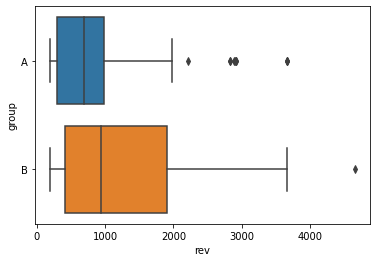

In [27]:
#постройка графика ящика с усами
sns.boxplot(x=df_rev['rev'], y= df_rev['group'])

Есть значения за пределами 3 квартиля, но для исследования их лучше оставить, возможно влияние количества таких покупок зависит от введения новой системы оплаты

---



In [28]:
active_checks = pd.merge(active,checks,on='student_id', how='outer')
no_active_checs = active_checks.loc[active_checks['group_x'].isna()]
len(no_active_checs['student_id'].unique())

149

Есть несостыковка в данных таблицы активных клиентов в период исследования и клентов совершивших оплату в данный период на 149 id. Возможно есть необходимость проверить систему регистрации активности клиентов, либо есть нюансы в системе оплаты. В дальнейшем проведение расчета метрик проводились в двух форматах. Т.е. 1 -  это клиенты совершившие оплату считались соответсвенно активными. 2 - эти клиенты не входили в категорию активных при расчете метрик. При проверке гипотез брался 1 вариант расчета.

In [29]:
#айди не попавшие в список активных
no_active_checs

,student_id,group_x,rev,group_y
8341,3185,NaN,690.0,B
8342,25973,NaN,690.0,B
8343,26280,NaN,690.0,B
8344,100645,NaN,630.0,B
8345,102534,NaN,580.0,B
...,...,...,...,...
8485,5291900,NaN,199.0,B
8486,5331842,NaN,290.0,B
8487,5486319,NaN,199.0,B
8488,5562806,NaN,398.0,B


In [30]:
#создание датафрейма с клиентами только из списка активных
only_active_pay = active_checks.loc[~active_checks['group_x'].isna()]
display(only_active_pay.info())
only_active_pay

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   group_x     8341 non-null   object 
 2   rev         392 non-null    float64
 3   group_y     392 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 325.8+ KB


None

,student_id,group_x,rev,group_y
0,581585,A,NaN,NaN
1,5723133,A,NaN,NaN
2,3276743,B,NaN,NaN
3,4238589,A,NaN,NaN
4,4475369,B,NaN,NaN
...,...,...,...,...
8336,1794344,B,NaN,NaN
8337,296883,B,NaN,NaN
8338,3598448,B,NaN,NaN
8339,3610547,B,290.0,B


In [31]:
#разделение на группы
only_active_pay_a = only_active_pay.query('group_x == "A"')
only_active_pay_b = only_active_pay.query('group_x == "B"')

In [32]:
#выведение информации о таблицах
display(only_active_pay_a.head())
only_active_pay_b.head()

,student_id,group_x,rev,group_y
0,581585,A,NaN,NaN
1,5723133,A,NaN,NaN
3,4238589,A,NaN,NaN
7,1394612,A,NaN,NaN
21,5194768,A,NaN,NaN


,student_id,group_x,rev,group_y
2,3276743,B,NaN,NaN
4,4475369,B,NaN,NaN
5,5481015,B,NaN,NaN
6,1353433,B,NaN,NaN
8,1170611,B,NaN,NaN


# 2. Расчета метрик

**Конверсия** из активных в оплатившие

In [33]:
#функция для подсчета конверсии
def convers(series1,series2):
  conv = series1.count() / series2.count() *100
  return conv

In [34]:
display(f"Конверсия общего количества активных и платящих пользователей {convers(df['rev'],df['student_id']).round(2)} %")
display(f"Конверсия общего количества активных пользователей {convers(only_active_pay['rev'],only_active_pay['student_id']).round(2)} %")


'Конверсия общего количества активных и платящих пользователей 6.37 %'

'Конверсия общего количества активных пользователей 4.7 %'

In [35]:
display(f"Конверсия общего количества активных и платящих пользователей группы А {convers(df_a['rev'],df_a['student_id']).round(2)} %")
display(f"Конверсия общего количества активных пользователей группы А {convers(only_active_pay_a['rev'],only_active_pay_a['student_id']).round(2)} %")

'Конверсия общего количества активных и платящих пользователей группы А 6.83 %'

'Конверсия общего количества активных пользователей группы А 5.07 %'

In [36]:
display(f"Конверсия общего количества активных и платящих пользователей группы B {convers(df_b['rev'],df_b['student_id']).round(2)} %")
display(f"Конверсия общего количества активных пользователей группы B {convers(only_active_pay_b['rev'],only_active_pay_b['student_id']).round(2)} %")

'Конверсия общего количества активных и платящих пользователей группы B 6.27 %'

'Конверсия общего количества активных пользователей группы B 4.62 %'

**ARPAU(средний доход, который получаем от каждого активного пользователя)**

In [37]:
#функция для расчета ARPAU
def arpu(series1,df):
  arpu_metric = series1.sum() / df.shape[0]
  return arpu_metric


In [38]:
display(f"ARPAU общего количества активных и платящих пользователей {arpu(df['rev'],df).round(2)} руб.")
display(f"ARPAU общего количества активных пользователей {arpu(only_active_pay['rev'],only_active_pay).round(2)} руб.")


'ARPAU общего количества активных и платящих пользователей 67.53 руб.'

'ARPAU общего количества активных пользователей 56.08 руб.'

In [39]:
display(f"ARPAU общего количества активных и платящих пользователей группы А {arpu(df_a['rev'],df_a).round(2)} руб.")
display(f"ARPAU общего количества активных пользователей группы А {arpu(only_active_pay_a['rev'],only_active_pay_a).round(2)} руб.")


'ARPAU общего количества активных и платящих пользователей группы А 58.77 руб.'

'ARPAU общего количества активных пользователей группы А 47.35 руб.'

In [40]:
display(f"ARPAU общего количества активных и платящих пользователей группы B {arpu(df_b['rev'],df_b).round(2)} руб.")
display(f"ARPAU общего количества активных пользователей группы B {arpu(only_active_pay_b['rev'],only_active_pay_b).round(2)} руб.")

'ARPAU общего количества активных и платящих пользователей группы B 69.51 руб.'

'ARPAU общего количества активных пользователей группы B 58.06 руб.'

**ARPPU(средний доход получаемы от каждого платящего клиента за этот период)**

In [41]:
display(f"Средний доход от каждого платящего клиента {df_rev['rev'].mean()}")
display(f"Средний доход от каждого платящего клиента группы А {df_rev_a['rev'].mean()}")
display(f"Средний доход от каждого платящего клиента группы B {df_rev_b['rev'].mean()}")

'Средний доход от каждого платящего клиента 1059.7523171903883'

'Средний доход от каждого платящего клиента группы А 860.7102803738318'

'Средний доход от каждого платящего клиента группы B 1108.824893087558'

In [42]:
#средняя доход от каждой группы клиентов в исследуемый период
df_rev.groupby('group').agg({'rev':['sum','mean']})

rev             
               sum         mean
group                          
A       92096.0000   860.710280
B      481230.0036  1108.824893

**Paying share(это ARPAU / ARPPu - Доля платящих пользователей)**

In [43]:
display(f"Общая доля платящих клиентов {(df['rev'].sum() / df.shape[0]) / df_rev['rev'].mean() * 100}")
display(f"Общая доля платящих клиентов группы А {(df_a['rev'].sum() / df_a.shape[0]) / df_rev['rev'].mean() * 100}")
display(f"Общая доля платящих клиентов группы B {(df_b['rev'].sum() / df_b.shape[0]) / df_rev['rev'].mean() * 100}")

'Общая доля платящих клиентов 6.3722025912838625'

'Общая доля платящих клиентов группы А 5.545840776131002'

'Общая доля платящих клиентов группы B 6.559247075516786'

Из рассмотренных метрик можно сделать следующий выводы:
- В исследуемом периоде конверсия группы А выше, чем конверсия группы B, как в рассматриваемых данных , где все оплатившие входят в группу активных, так и в изначальной группе активных. Статистическую значимость данной разницы проверим в гипотезах.
- Средний доход полученный с активного клиента в исследуемый период выше в группе B на 15,5 %
- Средний доход полученный с оплатившего клиента в исследуемый период выше в группе B на 22,4 %
- Общая доля платящих клиентов в группе B выше на 1%.

# 3. Проверка гипотез

### 3.1 Средняя выручка пользователей группы B отличается от средней выручки группы А

In [44]:
f"Средняя выручка группы B выше средней выручки группы B на {round(df_rev_b['rev'].mean() - df_rev_a['rev'].mean(),2)} руб., {abs(round(df_rev_a['rev'].mean()/ df_rev_b['rev'].mean()*100-100,2))} %"

'Средняя выручка группы B выше средней выручки группы B на 248.11 руб., 22.38 %'

H0 средняя выручка пользователей группы B не отличается от средней выручки пользователей группы A<br>
H1 средняя выручка пользователей группы B отличается от средней выручки пользователей группы A

In [45]:
#проверка различия дисперсий
df_rev_a['rev'].var()/df_rev_b['rev'].var()

1.2096314317751442

Для проверки гипотез применим U-тест Манна-Уитни.

In [46]:
#функция для проведения теста
def mn(series1,series2,alpha=0.05): # критический уровень статистической значимости 5%
  result = st.mannwhitneyu(series1,series2)
  print('p-значение:', result.pvalue)

  if (result.pvalue < alpha):
      print("Отвергаем нулевую гипотезу")
  else:
      print("Не получилось отвергнуть нулевую гипотезу")  

In [47]:
#запуск функции теста
mn(df_rev_a['rev'],df_rev_b['rev'])

p-значение: 9.658027498190076e-05
Отвергаем нулевую гипотезу


In [48]:
#запуск функции теста
mn(df_rev_a['rev'],df_rev_b['rev'],alpha=0.01)# критический уровень статистической значимости 1%

p-значение: 9.658027498190076e-05
Отвергаем нулевую гипотезу


### 3.2 Конверсия пользователей группы B отличается от конверсии группы А

In [49]:
#сделаем ноывй датафрейм для проведения теста
df_for_test = df.fillna(0)# заменим пропущенные значения на 0 для дальнейшей категоризации

In [50]:
#функция для присвоения категорий
def category(rev):
  if rev > 0:
    return 1
  return 0
df_for_test['cat'] = df_for_test['rev'].apply(category)

In [51]:
#разделение датафрейма по группам
df_for_test_a = df_for_test.query('group == "A"')
df_for_test_b = df_for_test.query('group == "B"')

H0 Конверсия группы B не отличается от конверсии пользователей группы A <br>
H1 Конверсия пользователей группы B отличается от конверсии пользователей группы A

In [52]:
#запуск функции теста
mn(df_for_test_a['cat'],df_for_test_b['cat'])# критический уровень статистической значимости 5%

p-значение: 0.20651816228128556
Не получилось отвергнуть нулевую гипотезу


# Вывод

Было проведено тестирование новой механики оплаты услуг на сайте. Для этих целей клиенты были разделены на две группы: группа А - клиенты пользующиеся старой механикой оплаты и группа B - клиенты, которые предоставили для использования новую механику оплаты.
<br>
Исходя из совокупности полученных данных, были исследованы метрики: конверсия активных клиентов перешедших в покупку, средний доход от одного активного пользователя, средний доход от одного платящего пользователя, доля платящих пользователей.
Были выявлены различия в показателях между исследуемыми группами в конверсии и среднего дохода от клиентов.
- В исследуемом периоде конверсия группы А выше, чем конверсия группы B, как в рассматриваемых данных , где все оплатившие входят в группу активных, так и в изначальной группе активных. Статистическую значимость данной разницы проверим в гипотезах.
- Средний доход полученный с активного клиента в исследуемый период выше в группе B на 15,5 %
- Средний доход полученный с оплатившего клиента в исследуемый период выше в группе B на 22,4 %
- Общая доля платящих клиентов в группе B выше на 1%.
<br>
Исходя из выявленных различий были проведены статистические тесты для проверки гипотез, которые выявили:
- средняя выручка пользователей группы B отличается от средней выручки пользователей группы A, следовательно полученная разница является результатов использования новой механики оплаты на сайте
- не смогли отвергнуть гипотезу, что конверсия группы А при переходе от активного клиента к оплате выше , чем конверсия группы B, следовательно с большей долей вероятности данный результат мог был получен случайно
<br>
По результату проведенного исследования можно сказать, что выявлена явная зависимость роста среднего дохода полученного от клиента при  использовании новой механики оплаты. Данную механику стоит запускать на всех пользователей.